# 🤗 Huggingface vs ⚡ FastEmbed️

Comparing the performance of Huggingface's 🤗 Transformers and ⚡ FastEmbed️ on a simple task (GPU)
## 📦 Imports

Importing the necessary libraries for this comparison.

In [37]:
!pip install fastembed-gpu

In [38]:
!pip3 install torch transformers matplotlib

In [39]:
import time
from typing import Callable

import torch
import torch.nn.functional as F
from fastembed import TextEmbedding
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer

## 📖 Data

data is a list of strings, each string is a document.

In [40]:
documents: list[str] = [
    "Chandrayaan-3 is India's third lunar mission",
    "It aimed to land a rover on the Moon's surface - joining the US, China and Russia",
    "The mission is a follow-up to Chandrayaan-2, which had partial success",
    "Chandrayaan-3 will be launched by the Indian Space Research Organisation (ISRO)",
    "The estimated cost of the mission is around $35 million",
    "It will carry instruments to study the lunar surface and atmosphere",
    "Chandrayaan-3 landed on the Moon's surface on 23rd August 2023",
    "It consists of a lander named Vikram and a rover named Pragyan similar to Chandrayaan-2. Its propulsion module would act like an orbiter.",
    "The propulsion module carries the lander and rover configuration until the spacecraft is in a 100-kilometre (62 mi) lunar orbit",
    "The mission used GSLV Mk III rocket for its launch",
    "Chandrayaan-3 was launched from the Satish Dhawan Space Centre in Sriharikota",
    "Chandrayaan-3 was launched earlier in the year 2023",
]
len(documents)

12

In [41]:
model_id = "BAAI/bge-small-en"

## Setting up 🤗 Huggingface

We'll be using the [Huggingface Transformers](https://huggingface.co/transformers/) with PyTorch library to generate embeddings. We'll be using the same model across both libraries for a fair(er?) comparison.

In [42]:
class HF:
    """
    HuggingFace Transformer implementation of FlagEmbedding
    Based on https://huggingface.co/BAAI/bge-base-en
    """

    def __init__(
        self, model_id: str, device: str = "cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.device = device
        self.model = AutoModel.from_pretrained(model_id).to(self.device)
        self.tokenizer = AutoTokenizer.from_pretrained(model_id)

    def embed(self, texts: list[str]):
        encoded_input = self.tokenizer(
            texts, max_length=512, padding=True, truncation=True, return_tensors="pt"
        ).to(self.device)

        model_output = self.model(**encoded_input)
        sentence_embeddings = model_output[0][:, 0]
        sentence_embeddings = F.normalize(sentence_embeddings)
        return sentence_embeddings


hf = HF(model_id=model_id)
hf.embed(documents).shape

torch.Size([12, 384])

## Setting up ⚡️FastEmbed

Sorry, don't have a lot to set up here. We'll be using the default model, which is Flag Embedding, same as the Huggingface model.

In [43]:
embedding_model = TextEmbedding(model_name=model_id, cuda=True)

## 📊 Comparison

We'll be comparing the following metrics: Minimum, Maximum, Mean, across k runs. Let's write a function to do that:

### 🚀 Calculating Stats

In [44]:
import types


def calculate_time_stats(
    embed_func: Callable, documents: list[str], k: int
) -> tuple[float, float, float]:
    times = []
    for _ in range(k):
        # Timing the embed_func call
        start_time = time.time()
        embeddings = embed_func(documents)
        # Force computation if embed_func returns a generator
        if isinstance(embeddings, types.GeneratorType):
            list(embeddings)

        end_time = time.time()
        times.append(end_time - start_time)

    # Returning mean, max, and min time for the call
    return (sum(times) / k, max(times), min(times))


hf_stats = calculate_time_stats(hf.embed, documents, k=100)
print(f"Huggingface Transformers (Average, Max, Min): {hf_stats}")
fst_stats = calculate_time_stats(embedding_model.embed, documents, k=100)
print(f"FastEmbed (Average, Max, Min): {fst_stats}")

Huggingface Transformers (Average, Max, Min): (0.014735164642333985, 0.03357124328613281, 0.011344671249389648)
FastEmbed (Average, Max, Min): (0.008367671966552734, 0.020212650299072266, 0.006894826889038086)


## 📈 Results

Let's run the comparison and see the results.

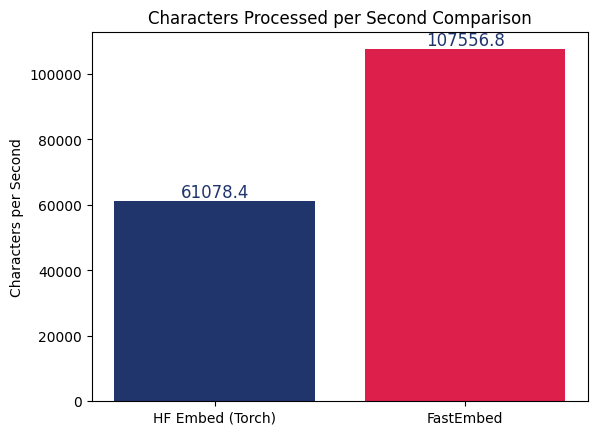

In [45]:
def plot_character_per_second_comparison(
    hf_stats: tuple[float, ...], fst_stats: tuple[float, ...], documents: list[str]
):
    # Calculating total characters in documents
    total_characters = sum(len(doc) for doc in documents)

    # Calculating characters per second for each model
    hf_chars_per_sec = total_characters / hf_stats[0]  # Mean time is at index 0
    fst_chars_per_sec = total_characters / fst_stats[0]

    # Plotting the bar chart
    models = ["HF Embed (Torch)", "FastEmbed"]
    chars_per_sec = [hf_chars_per_sec, fst_chars_per_sec]

    bars = plt.bar(models, chars_per_sec, color=["#1f356c", "#dd1f4b"])
    plt.ylabel("Characters per Second")
    plt.title("Characters Processed per Second Comparison")

    # Adding the number at the top of each bar
    for bar, chars in zip(bars, chars_per_sec):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{chars:.1f}",
            ha="center",
            va="bottom",
            color="#1f356c",
            fontsize=12,
        )

    plt.show()


plot_character_per_second_comparison(hf_stats, fst_stats, documents)